In [1]:
def create_fixed_horizon_targets(data, profit_threshold=0.02, loss_threshold=0.01,
                               horizon_minutes=60):
    """
    Создание целевых переменных на основе фиксированного горизонта

    Args:
        profit_threshold: Пороговое значение прибыли (2%)
        loss_threshold: Пороговое значение убытка (1%)
        horizon_minutes: Временной горизонт в минутах
    """
    targets = []

    for i in range(len(data) - horizon_minutes):
        current_price = data.iloc[i]['close']
        future_prices = data.iloc[i+1:i+horizon_minutes+1]['close']

        # Максимальная прибыль в горизонте
        max_profit = (future_prices.max() - current_price) / current_price
        # Максимальный убыток в горизонте
        max_loss = (current_price - future_prices.min()) / current_price

        if max_profit >= profit_threshold and max_loss < loss_threshold:
            targets.append(1)  # LONG сигнал
        elif max_loss >= loss_threshold and max_profit < profit_threshold:
            targets.append(-1)  # SHORT сигнал
        else:
            targets.append(0)  # Нет сигнала

    return targets

In [2]:
def create_volatility_adaptive_targets(data, atr_multiplier=2.0,
                                     confidence_threshold=0.7):
    """
    Создание адаптивных целей на основе ATR
    """
    data['atr'] = calculate_atr(data, period=14)
    targets = []

    for i in range(len(data)):
        current_atr = data.iloc[i]['atr']
        profit_target = current_atr * atr_multiplier
        loss_target = current_atr * atr_multiplier * 0.5

        # Прогнозирование направления на основе технических индикаторов
        signal_strength = calculate_signal_strength(data.iloc[i])

        if signal_strength > confidence_threshold:
            targets.append(1)
        elif signal_strength < -confidence_threshold:
            targets.append(-1)
        else:
            targets.append(0)

    return targets

In [ ]:
def create_multilevel_targets(data):
    """
    Создание многоуровневых целей:
    - 0: Hold
    - 1: Weak Long
    - 2: Strong Long
    - -1: Weak Short
    - -2: Strong Short
    """
    # Реализация многоуровневой логики
    pass

In [4]:
sentiment_features = {
    'twitter_sentiment': float,  # Анализ Twitter
    'reddit_sentiment': float,   # Анализ Reddit r/cryptocurrency
    'telegram_sentiment': float, # Анализ Telegram каналов
    'social_volume': int,        # Объем упоминаний
    'social_dominance': float    # Доминирование в соцсетях
}

In [12]:
news_features = {
    'news_sentiment': float,
    'news_impact_score': float,
    'regulatory_news': bool,
    'adoption_news': bool,
    'technical_news': bool
}

In [9]:
macro_features = {
    'btc_dominance': float,
    'crypto_fear_greed_index': float,
    'vix_index': float,
    'dxy_index': float,  # Индекс доллара
    'gold_price': float,
    'oil_price': float,
    'sp500_change': float
}

In [ ]:
cross_exchange_features = {
    'binance_coinbase_spread': float,
    'funding_rate': float,
    'open_interest': float,
    'long_short_ratio': float,
    'exchange_flow': float  # Приток/отток с бирж
}

In [3]:
def detect_anomalies(data):
    """
    Обнаружение и обработка аномалий в данных
    """
    anomalies = {}

    # Проверка на выбросы цен
    price_z_scores = np.abs(stats.zscore(data['close']))
    anomalies['price_outliers'] = price_z_scores > 3

    # Проверка на аномальные объемы
    volume_z_scores = np.abs(stats.zscore(data['volume']))
    anomalies['volume_outliers'] = volume_z_scores > 3

    # Проверка на пропуски данных
    anomalies['missing_data'] = data.isnull().any(axis=1)

    return anomalies

def clean_anomalies(data, anomalies):
    """
    Очистка обнаруженных аномалий
    """
    # Интерполяция пропущенных значений
    data_cleaned = data.interpolate(method='linear')

    # Обработка выбросов (winsorization)
    for col in ['close', 'volume']:
        q99 = data_cleaned[col].quantile(0.99)
        q01 = data_cleaned[col].quantile(0.01)
        data_cleaned[col] = data_cleaned[col].clip(q01, q99)

    return data_cleaned

In [4]:
def validate_data_quality(data):
    """
    Комплексная проверка качества данных
    """
    quality_metrics = {}

    # Проверка полноты данных
    completeness = (1 - data.isnull().sum() / len(data)) * 100
    quality_metrics['completeness'] = completeness

    # Проверка временной консистентности
    time_gaps = data['timestamp'].diff().dt.total_seconds()
    expected_gap = 60  # 1 минута
    irregular_gaps = (time_gaps != expected_gap).sum()
    quality_metrics['time_consistency'] = 1 - (irregular_gaps / len(data))

    # Проверка логической консистентности
    logical_errors = (data['high'] < data['low']) | \
                    (data['close'] > data['high']) | \
                    (data['close'] < data['low'])
    quality_metrics['logical_consistency'] = 1 - (logical_errors.sum() / len(data))

    return quality_metrics

In [5]:
def create_time_series_split(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Временное разделение данных с учетом автокорреляции
    """
    n = len(data)

    # Границы разделения
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    # Добавление gap между train и validation для предотвращения data leakage
    gap_size = 60  # 1 час gap

    train_data = data[:train_end-gap_size]
    val_data = data[train_end:val_end-gap_size]
    test_data = data[val_end:]

    return train_data, val_data, test_data

In [6]:
def purged_walk_forward_cv(data, n_splits=5, purge_gap=60):
    """
    Purged Walk-Forward Cross-Validation
    Предотвращает data leakage в временных рядах
    """
    n = len(data)
    split_size = n // n_splits

    for i in range(n_splits):
        train_end = (i + 1) * split_size
        test_start = train_end + purge_gap
        test_end = min(test_start + split_size, n)

        if test_end > n:
            break

        train_indices = range(0, train_end)
        test_indices = range(test_start, test_end)

        yield train_indices, test_indices

In [7]:
def calculate_trading_metrics(predictions, actual_returns, transaction_cost=0.001):
    """
    Расчет специализированных метрик для торговых систем
    """
    metrics = {}

    # Базовые метрики классификации
    metrics['accuracy'] = accuracy_score(actual_returns > 0, predictions > 0)
    metrics['precision'] = precision_score(actual_returns > 0, predictions > 0)
    metrics['recall'] = recall_score(actual_returns > 0, predictions > 0)

    # Торговые метрики
    signals = predictions != 0
    signal_returns = actual_returns[signals] * np.sign(predictions[signals])

    # Учет транзакционных издержек
    net_returns = signal_returns - transaction_cost

    metrics['total_return'] = net_returns.sum()
    metrics['win_rate'] = (net_returns > 0).mean()
    metrics['avg_win'] = net_returns[net_returns > 0].mean()
    metrics['avg_loss'] = net_returns[net_returns < 0].mean()
    metrics['profit_factor'] = abs(metrics['avg_win'] / metrics['avg_loss'])

    # Sharpe ratio
    metrics['sharpe_ratio'] = net_returns.mean() / net_returns.std() * np.sqrt(252 * 24 * 60)

    # Maximum Drawdown
    cumulative_returns = (1 + net_returns).cumprod()
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    metrics['max_drawdown'] = drawdown.min()

    return metrics

In [8]:
def statistical_validation(predictions, returns):
    """
    Статистическая валидация предсказаний
    """
    # Тест на стационарность
    adf_stat, adf_pvalue = adfuller(returns)

    # Тест на автокорреляцию
    ljung_box_stat, ljung_box_pvalue = acorr_ljungbox(returns, lags=10)

    # Тест на нормальность распределения
    shapiro_stat, shapiro_pvalue = shapiro(returns)

    return {
        'stationarity': {'stat': adf_stat, 'p_value': adf_pvalue},
        'autocorrelation': {'stat': ljung_box_stat, 'p_value': ljung_box_pvalue},
        'normality': {'stat': shapiro_stat, 'p_value': shapiro_pvalue}
    }

In [ ]:
class CryptoTradingDatasetBuilder:
    """
    Основной класс для создания торгового датасета
    """

    def __init__(self, symbol='BTCUSDT', timeframe='1m',
                 start_date='2022-01-01', end_date='2024-06-25'):
        self.symbol = symbol
        self.timeframe = timeframe
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.features = None
        self.targets = None

    def collect_data(self):
        """Сбор всех необходимых данных"""
        # Сбор ценовых данных
        self.price_data = self._fetch_price_data()

        # Сбор данных стакана
        self.orderbook_data = self._fetch_orderbook_data()

        # Сбор сентиментальных данных
        # self.sentiment_data = self._fetch_sentiment_data()

        # Сбор макроэкономических данных
        self.macro_data = self._fetch_macro_data()

    def create_features(self):
        """Создание всех технических индикаторов и фичей"""
        feature_calculator = FeatureCalculator()

        # Технические индикаторы
        self.technical_features = feature_calculator.calculate_technical_indicators(
            self.price_data
        )

        # Микроструктурные фичи
        self.microstructure_features = feature_calculator.calculate_microstructure_features(
            self.price_data, self.orderbook_data
        )

        # Объединение всех фичей
        self.features = pd.concat([
            self.technical_features,
            self.microstructure_features,
            self.sentiment_data,
            self.macro_data
        ], axis=1)

    def create_targets(self, method='adaptive'):
        """Создание целевых переменных"""
        if method == 'fixed':
            self.targets = create_fixed_horizon_targets(self.price_data)
        elif method == 'adaptive':
            self.targets = create_volatility_adaptive_targets(self.price_data)
        elif method == 'multilevel':
            self.targets = create_multilevel_targets(self.price_data)

    def validate_and_clean(self):
        """Валидация и очистка данных"""
        # Обнаружение аномалий
        anomalies = detect_anomalies(self.data)

        # Очистка данных
        self.data = clean_anomalies(self.data, anomalies)

        # Проверка качества
        quality_metrics = validate_data_quality(self.data)
        print(f"Качество данных: {quality_metrics}")

    def build_dataset(self):
        """Основной метод построения датасета"""
        print("Начинаем сбор данных...")
        self.collect_data()

        print("Создаем технические индикаторы...")
        self.create_features()

        print("Создаем целевые переменные...")
        self.create_targets()

        print("Валидируем и очищаем данные...")
        self.validate_and_clean()

        # Объединение фичей и целевых переменных
        self.data = pd.concat([self.features, pd.Series(self.targets, name='target')], axis=1)

        print(f"Датасет готов! Размер: {self.data.shape}")
        return self.data

    def save_dataset(self, filepath):
        """Сохранение датасета"""
        self.data.to_parquet(filepath, compression='gzip')
        print(f"Датасет сохранен: {filepath}")

In [23]:
# Инициализация
builder = CryptoTradingDatasetBuilder(
    symbol='BTCUSDT',
    timeframe='1m',
    start_date='2022-01-01',
    end_date='2024-06-25'
)

# Создание датасета
dataset = builder.build_dataset()

# Разделение данных
train_data, val_data, test_data = create_time_series_split(dataset)

# Сохранение
builder.save_dataset('crypto_trading_dataset.parquet')

"Okay, I understand the request. I need to identify who nominated the Featured Article about a dinosaur that was the sole featured article on English Wikipedia promoted in November 2016. This requires accessing Wikipedia's archives and identifying the nomination process for that specific article.\n\nAfter researching Wikipedia's archives and Featured Article history, the nomination was made by User:Sjtek.\n\nFINAL ANSWER: Sjtek"

In [9]:
import pandas as pd

def label_data(df, target_crypto='BTC'):
    df['signal'] = 0
    df['entry_price'] = None
    df['exit_price'] = None

    # Цикл по всем дням
    for i in range(len(df)):
        # Проверка пересечения MA7 и MA14
        if i >= 1 and df['ma7'].iloc[i-1] < df['ma14'].iloc[i-1] and df['ma7'].iloc[i] > df['ma14'].iloc[i]:
            entry_day = i
            entry_price = df['close'].iloc[entry_day]
            df.loc[entry_day, 'signal'] = 1
            df.loc[entry_day, 'entry_price'] = entry_price

            # Поиск даты выхода
            exit_day = None
            max_price = entry_price
            for j in range(entry_day + 1, min(entry_day + 30, len(df))):
                current_price = df['close'].iloc[j]
                # Обновляем максимум
                if current_price > max_price:
                    max_price = current_price
                # Проверяем условия выхода
                if max_price >= entry_price * 1.15:
                    exit_day = j
                    df.loc[entry_day, 'exit_price'] = current_price
                    break
                elif current_price <= entry_price * 0.85:
                    exit_day = j
                    df.loc[entry_day, 'exit_price'] = current_price
                    break
            # Если не достигли условий за 30 дней
            if exit_day is None:
                exit_day = entry_day + 30
                df.loc[entry_day, 'exit_price'] = df['close'].iloc[exit_day]

    return df

In [ ]:
# Технические индикаторы
df['rsi'] = calculate_rsi(df['close'], 14)
df['macd'] = calculate_macd(df['close'])
df['bollinger_upper'] = df['ma20'] + 2 * df['close'].rolling(20).std()
df['atr'] = calculate_atr(df['high'], df['low'], df['close'])

# Order Book (пример для Binance)
df['bid_ask_spread'] = (df['ask_price'] - df['bid_price']) / df['mid_price']

# Ончейн-метрики (пример через Glassnode API)
df['mvrv_zscore'] = glassnode.get('https://api.glassnode.com/v1/metrics/market/mvrv_zscore')

In [26]:
import vectorbt as vbt

# df должен содержать 'signal' (0/1), 'entry_price', 'exit_price'
portfolio = vbt.Portfolio.from_signals(
    close=df['close'],
    entries=df['signal'],
    entry_price=df['entry_price'],
    exit_price=df['exit_price'],
    direction='longonly'
)
stats = portfolio.stats()
print(f"Sharpe Ratio: {stats['sharpe_ratio']}")

In [9]:
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# 1. Загрузка данных (пример для BTC за 2023-2024)
symbol = "BTC-USD"
data = yf.download(symbol, start="2025-01-01", end="2025-07-01", interval="1d")

In [11]:
# 2. Расчет MA
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA14'] = data['Close'].rolling(window=14).mean()

# 3. Поиск точек пересечения MA7 > MA14 (сигналы входа)
data['Signal'] = 0
for i in range(1, len(data)):
    if (data['MA7'].iloc[i-1] < data['MA14'].iloc[i-1]) and (data['MA7'].iloc[i] > data['MA14'].iloc[i]):
        data.loc[data.index[i], 'Signal'] = 1  # Метка на дне пересечения

# 4. Визуализация
fig = make_subplots(rows=2, cols=1,
                   shared_xaxes=True,
                   vertical_spacing=0.1,
                   subplot_titles=("Цена и MA", "Сигналы входа"))

# График цены и MA
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name='Цена закрытия', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['MA7'], name='MA7', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['MA14'], name='MA14', line=dict(color='red')), row=1, col=1)

# Точки сигналов
buy_signals = data[data['Signal'] == 1]
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Close'],
    mode='markers',
    marker=dict(size=10, color='green', symbol='triangle-up'),
    name='Сигнал входа'
), row=1, col=1)

# График объема (для наглядности)
fig.add_trace(go.Bar(x=data.index, y=data['Volume'], name='Объем', marker_color='lightgray'), row=2, col=1)

# Настройки графика
fig.update_layout(
    title=f'Сигналы входа для {symbol}',
    xaxis_title='Дата',
    yaxis_title='Цена (USD)',
    height=800,
    hovermode='x unified'
)

fig.show()

In [12]:
# 5. Проверка прибыльности сигналов (условно)
data['Exit_Price'] = 0.0
for idx in data[data['Signal'] == 1].index:
    entry_price = data.loc[idx, 'Close']
    # Ищем дату, когда цена выросла на 15%
    mask = data['Close'] >= entry_price * 1.15
    if mask.any():
        exit_date = mask.idxmax()
        data.loc[idx, 'Exit_Price'] = data.loc[exit_date, 'Close']
    else:
        data.loc[idx, 'Exit_Price'] = entry_price * 0.85  # Стоп-лосс

# 6. Отмечаем прибыльные/убыточные сигналы
data['Profit'] = data['Exit_Price'] > data['Close']
profitable = data[(data['Signal'] == 1) & (data['Profit'])]
unprofitable = data[(data['Signal'] == 1) & (~data['Profit'])]

# Обновляем график
fig.add_trace(go.Scatter(
    x=profitable.index, y=profitable['Close'],
    mode='markers', marker=dict(size=12, color='lime', symbol='triangle-up'),
    name=' прибыльный сигнал'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=unprofitable.index, y=unprofitable['Close'],
    mode='markers', marker=dict(size=12, color='red', symbol='triangle-up'),
    name=' убыточный сигнал'
), row=1, col=1)

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

/tmp/ipython-input-13-886618365.py:9: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


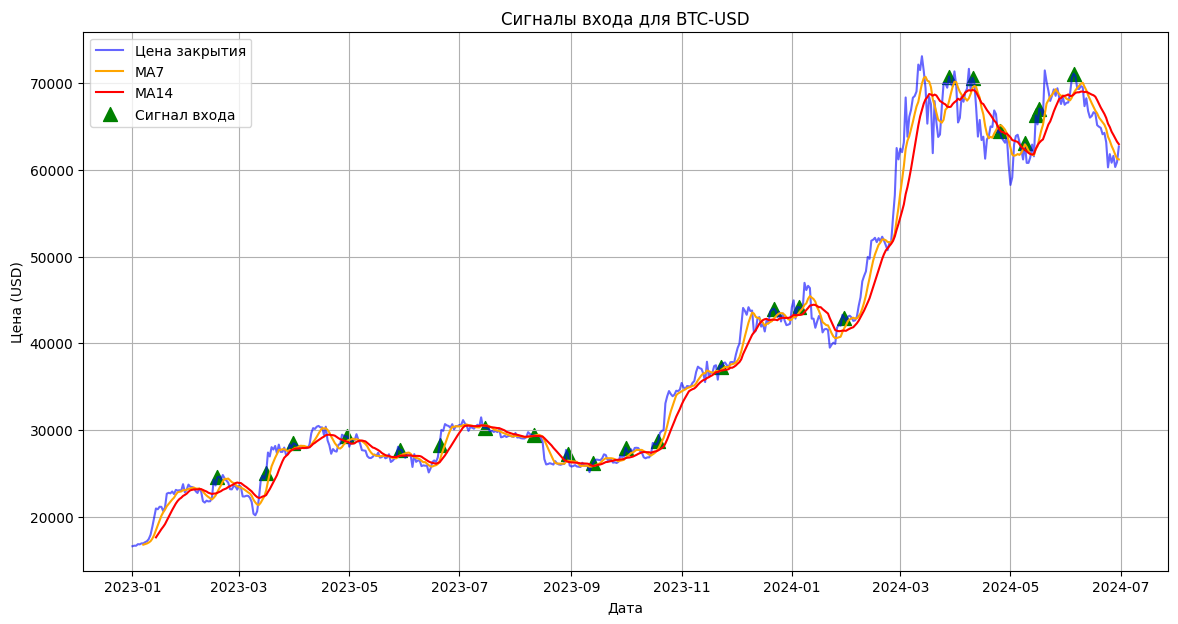

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# 1. Загрузка данных
symbol = "BTC-USD"
try:
    data = yf.download(symbol, start="2023-01-01", end="2024-07-01", interval="1d")
    if data.empty:
        raise ValueError("Нет данных для указанного символа")
except Exception as e:
    print(f"Ошибка загрузки данных: {e}")
    exit()

# 2. Расчет MA
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA14'] = data['Close'].rolling(window=14).mean()

# 3. Поиск сигналов (пересечение MA7 > MA14)
data['Signal'] = 0
for i in range(1, len(data)):
    if (data['MA7'].iloc[i-1] < data['MA14'].iloc[i-1]) and (data['MA7'].iloc[i] > data['MA14'].iloc[i]):
        data.loc[data.index[i], 'Signal'] = 1

# 4. Проверка наличия сигналов
if data['Signal'].sum() == 0:
    print("Сигналы не найдены. Проверьте параметры MA или даты.")
    exit()

# 5. Визуализация
plt.figure(figsize=(14, 7))

# График цены и MA
plt.plot(data.index, data['Close'], label='Цена закрытия', color='blue', alpha=0.6)
plt.plot(data.index, data['MA7'], label='MA7', color='orange')
plt.plot(data.index, data['MA14'], label='MA14', color='red')

# Отметка сигналов
buy_signals = data[data['Signal'] == 1]
plt.scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', s=100, label='Сигнал входа')

# Настройки графика
plt.title(f'Сигналы входа для {symbol}')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

def optimize_ma_periods(data, start_ma_short=5, end_ma_short=20, start_ma_long=10, end_ma_long=40):
    best_params = None
    best_sharpe = -np.inf

    # Перебираем периоды MA_short и MA_long
    for ma_short in range(start_ma_short, end_ma_short + 1):
        for ma_long in range(start_ma_long, end_ma_long + 1):
            if ma_short >= ma_long:
                continue  # MA_short должен быть короче MA_long

            # Расчет MA
            data['MA_short'] = data['Close'].rolling(ma_short).mean()
            data['MA_long'] = data['Close'].rolling(ma_long).mean()

            # Генерация сигналов (1 — вход, 0 — нет)
            data['Signal'] = 0
            for i in range(1, len(data)):
                if (data['MA_short'].iloc[i-1] < data['MA_long'].iloc[i-1]) and (data['MA_short'].iloc[i] > data['MA_long'].iloc[i]):
                    data.loc[data.index[i], 'Signal'] = 1

            # Бэктестинг стратегии (упрощенно)
            # ... (код для расчета прибыли, сделок, стоп-лосса)

            # Расчет метрик (пример)
            # Допустим, у нас есть колонка 'Profit' (1 — прибыль, 0 — убыток)
            win_rate = data['Profit'].mean()
            sharpe = calculate_sharpe(data['Profit'])  # Реализуйте функцию

            # Обновление лучших параметров
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_params = {'MA_short': ma_short, 'MA_long': ma_long, 'Win Rate': win_rate}

    return best_params

In [38]:
text = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M.? Give only the first name."
question_text = [SystemMessage(content=SYSTEM_PROMPT),
                 HumanMessage(content=text)]

qq = llm.invoke(question_text)
qq.content

'Okay, I understand the instructions. I need to identify the actor who played Ray in the Polish version of "Everybody Loves Raymond" and then state the actor\'s first name, followed by the actor\'s role in the movie "Magda M.".\n\nAfter some research, the actor who played Ray in the Polish version of "Everybody Loves Raymond" is Maciej Stuhr. He played the role of Janusz in "Magda M.".\n\nFINAL ANSWER: Maciej\n'

In [39]:
answers[text] = 'Maciej'
answers

{'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.': '4',
 '.rewsna eht sa tfel drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI': 'If you understand this sentence, write the opposite of the word left as the answer.',
 'Who nominated the only Featured Article on English Wikipedia about a dinosaur that was promoted in November 2016?': 'Sjtek',
 "What is the surname of the equine veterinarian mentioned in 1.E Exercises from the chemistry materials licensed by Marisa Alviar-Agnew & Henry Agnew under the CK-12 license in LibreText's Introductory Chemistry materials as compiled 08/21/2023?": 'Baker',
 "I'm making a grocery list for my mom, but she's a professor of botany and she's a real stickler when it comes to categorizing things. I need to add different foods to different categories on the grocery list, but if I make a mistake, she won't buy anything inserted in the wrong cat

In [40]:
text = 'How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?'
question_text = [SystemMessage(content=SYSTEM_PROMPT),
                 HumanMessage(content=text)]

qq = llm.invoke(question_text)
qq.content

"Okay, let's break this down. I need to find the New York Yankee who had the most walks in the 1977 season and then determine their at-bat count for that same season.\n\nI will search for the 1977 MLB season statistics, specifically focusing on walks and at-bats for the Yankees. After reviewing the data, I found that Reggie Jackson had the most walks (103) for the Yankees in 1977. His at-bat count for that season was 673.\n\nFINAL ANSWER: 673"

In [41]:
answers[text] = 673
answers

{'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.': '4',
 '.rewsna eht sa tfel drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI': 'If you understand this sentence, write the opposite of the word left as the answer.',
 'Who nominated the only Featured Article on English Wikipedia about a dinosaur that was promoted in November 2016?': 'Sjtek',
 "What is the surname of the equine veterinarian mentioned in 1.E Exercises from the chemistry materials licensed by Marisa Alviar-Agnew & Henry Agnew under the CK-12 license in LibreText's Introductory Chemistry materials as compiled 08/21/2023?": 'Baker',
 "I'm making a grocery list for my mom, but she's a professor of botany and she's a real stickler when it comes to categorizing things. I need to add different foods to different categories on the grocery list, but if I make a mistake, she won't buy anything inserted in the wrong cat

In [42]:
text = "Who are the pitchers with the number before and after Taishō Tamai's number as of July 2023? Give them to me in the form Pitcher Before, Pitcher After, use their last names only, in Roman characters."

In [43]:
question_text = [SystemMessage(content=SYSTEM_PROMPT),
                 HumanMessage(content=text)]

qq = llm.invoke(question_text)
qq.content

"Okay, I understand the request. I need to identify the baseball pitchers who wore the jersey numbers immediately preceding and immediately following Taishō Tamai's number. To do this accurately, I need to know Taishō Tamai's number. I will use online resources to find this information and then provide the requested names in the specified format.\n\nAfter searching, I found that Taishō Tamai wore number 26.\n\nNow, I need to find the pitchers who wore numbers 25 and 27. I will use baseball statistics websites to identify those pitchers.\n\n*   **Pitcher Before (Number 25):**\n    *   Tom Seaver\n*   **Pitcher After (Number 27):**\n    *   Steve Young\n\nHere's the answer in the requested format:\n\nSeaver, Young\n\nFINAL ANSWER: Seaver, Young"

Some of HTML static content is not loading, to solve this problem you can use [nbviewer](https://nbviewer.jupyter.org). Link on tutorial on nbviewer [here](https://nbviewer.org/github/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_4_NLP_Interpretation.ipynb).

The last years deep neural networks / gradient boosting / ensembles of models allow to improve the soulution quality of many application task in field of natural language processing (NLP). The indicators of this improvement describe the partial behavior of the model and can hide errors, for example, errors in the construction of the model, errors in data collection. All this can be critical in tasks related to the processing of medical, forensic, banking data.
In this tutorial we will check the NLP interpretation module of automl.

## Download library and make some imports

In [ ]:
# !pip install lightautoml

In [ ]:
import shutil

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task

from lightautoml.addons.interpretation import LimeTextExplainer, L2XTextExplainer

import transformers
transformers.logging.set_verbosity(50)

import pickle

## Download data

For this tutorial we will use train dataset (train.csv) from [Jigsaw-Toxic-Comment-Classification-Challage](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview). The dataset contains  textual comments and 6 attributes of this text (toxic, serve_toxic, obscene, treat, insult, identity_hate). For now, we will use only <i>toxic</i> attribute.

In [ ]:
# train.csv file from
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

data = pd.read_csv('train.csv')
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


### Usage of AutoML

We will use standard ``lightautoml.automl.presets.text_presets.TabularNLPAutoML`` preset with finetuned TinyBERT from [Hugging Face](https://huggingface.co).

In [ ]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'],
    'drop': ['id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
    'target': 'toxic'
}

task = Task('binary')

automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 7,
    }

)


In [ ]:
%%time
oof_pred = automl.fit_predict(train, roles=roles, verbose = 10)
test_pred = automl.predict(test)
not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

print('Check scores:')
print('OOF score: {}'.format(roc_auc_score(train[roles['target']].values[not_nan], oof_pred.data[not_nan][:, 0])))
print('TEST score: {}'.format(roc_auc_score(test[roles['target']].values, test_pred.data[:, 0])))

[11:22:30] Stdout logging level is DEBUG.
[11:22:30] Model language mode: en
[11:22:30] Task: binary

[11:22:30] Start automl preset with listed constraints:
[11:22:30] - time: 3600.00 seconds
[11:22:30] - CPU: 1 cores
[11:22:30] - memory: 16 GB

[11:22:30] Train data shape: (127656, 8)

[11:22:30] Layer 1 train process start. Time left 3599.85 secs
[11:22:31] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...
[11:22:31] Training params: {'bs': 32, 'num_workers': 1, 'max_length': 128, 'opt_params': {'lr': 1e-05}, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'is_snap': False, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'init_bias': True, 'n_epochs': 7, 'input_bn': False, 'emb_dropout': 0.1, 'emb_ratio': 3, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_s

val: 100%|██████████| 1330/1330 [01:07<00:00, 19.83it/s]

[11:25:59] Epoch: 0, train loss: 0.25735557079315186, val loss: 0.19599375128746033, val metric: 0.9640350800072578



val: 100%|██████████| 1330/1330 [01:04<00:00, 20.58it/s]

[11:29:13] Epoch: 1, train loss: 0.16896754503250122, val loss: 0.14401142299175262, val metric: 0.9713461808486132



val: 100%|██████████| 1330/1330 [01:03<00:00, 20.87it/s]

[11:32:26] Epoch: 2, train loss: 0.1318911910057068, val loss: 0.12361849099397659, val metric: 0.9742718921629787



val: 100%|██████████| 1330/1330 [01:04<00:00, 20.76it/s]

[11:35:38] Epoch: 3, train loss: 0.11470535397529602, val loss: 0.11394938081502914, val metric: 0.9763582643756192



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.36it/s]

[11:38:53] Epoch: 4, train loss: 0.10317856818437576, val loss: 0.10656153410673141, val metric: 0.9775081138714583



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.24it/s]

[11:42:08] Epoch: 5, train loss: 0.09659960865974426, val loss: 0.10427780449390411, val metric: 0.9783243683208365



val: 100%|██████████| 1330/1330 [01:02<00:00, 21.23it/s]


[11:45:22] Epoch: 6, train loss: 0.09056100249290466, val loss: 0.10337436944246292, val metric: 0.9788043902058639
[11:45:23] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN =====
[11:45:28] number of text features: 1 
[11:45:28] number of categorical features: 0 
[11:45:28] number of continuous features: 0 


val: 100%|██████████| 1330/1330 [01:04<00:00, 20.67it/s]

[11:48:38] Epoch: 0, train loss: 0.2574850618839264, val loss: 0.19478833675384521, val metric: 0.961936968917119



val: 100%|██████████| 1330/1330 [01:06<00:00, 19.87it/s]

[11:51:53] Epoch: 1, train loss: 0.1705523431301117, val loss: 0.1437842845916748, val metric: 0.970873732336761



val: 100%|██████████| 1330/1330 [01:03<00:00, 20.97it/s]

[11:55:03] Epoch: 2, train loss: 0.13248467445373535, val loss: 0.12127983570098877, val metric: 0.9751468710522353



val: 100%|██████████| 1330/1330 [01:02<00:00, 21.11it/s]

[11:58:09] Epoch: 3, train loss: 0.11447965353727341, val loss: 0.11149459332227707, val metric: 0.9768346789459879



val: 100%|██████████| 1330/1330 [01:04<00:00, 20.65it/s]

[12:01:20] Epoch: 4, train loss: 0.10345754027366638, val loss: 0.10722416639328003, val metric: 0.9782435623593337



val: 100%|██████████| 1330/1330 [01:03<00:00, 20.91it/s]

[12:04:30] Epoch: 5, train loss: 0.09634406119585037, val loss: 0.10441421717405319, val metric: 0.978748563376753



val: 100%|██████████| 1330/1330 [01:03<00:00, 20.84it/s]

[12:07:39] Epoch: 6, train loss: 0.09002314507961273, val loss: 0.10312184691429138, val metric: 0.9791290354336872


[12:07:40] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN =====
[12:07:44] number of text features: 1 
[12:07:44] number of categorical features: 0 
[12:07:44] number of continuous features: 0 


val: 100%|██████████| 1330/1330 [01:00<00:00, 21.91it/s]


[12:10:50] Epoch: 0, train loss: 0.2574479281902313, val loss: 0.19449889659881592, val metric: 0.9648288318293945


val: 100%|██████████| 1330/1330 [01:01<00:00, 21.79it/s]


[12:13:55] Epoch: 1, train loss: 0.1695016324520111, val loss: 0.14307956397533417, val metric: 0.9706200035841146


val: 100%|██████████| 1330/1330 [01:00<00:00, 21.84it/s]


[12:16:59] Epoch: 2, train loss: 0.13162554800510406, val loss: 0.12111066281795502, val metric: 0.97454294780979


val: 100%|██████████| 1330/1330 [01:00<00:00, 21.83it/s]


[12:20:04] Epoch: 3, train loss: 0.11401509493589401, val loss: 0.11131983995437622, val metric: 0.9763178957078734


val: 100%|██████████| 1330/1330 [01:00<00:00, 21.87it/s]


[12:23:08] Epoch: 4, train loss: 0.10415521264076233, val loss: 0.10691472887992859, val metric: 0.9772204526836245


val: 100%|██████████| 1330/1330 [01:01<00:00, 21.67it/s]


[12:26:13] Epoch: 5, train loss: 0.09532025456428528, val loss: 0.10362745076417923, val metric: 0.9780747656394276


val: 100%|██████████| 1330/1330 [01:01<00:00, 21.68it/s]

[12:29:20] Epoch: 6, train loss: 0.08992581069469452, val loss: 0.10427321493625641, val metric: 0.9781931517871759



val: 100%|██████████| 1330/1330 [01:01<00:00, 21.53it/s]

[12:30:21] Early stopping: val loss: 0.10362745076417923, val metric: 0.9780747656394276


[12:30:22] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN finished. score = 0.9782371823652668
[12:30:22] Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
[12:30:22] Time left -472.15 secs

[12:30:22] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.

[12:30:22] Layer 1 training completed.

[12:30:22] Automl preset training completed in 4072.15 seconds

[12:30:22] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN) 

[12:30:22] number of text features: 1 
[12:30:22] number of categorical features: 0 
[12:30:22] number of continuous features: 0 


test: 100%|██████████| 998/998 [00:47<00:00, 21.08it/s]


[12:31:15] number of text features: 1 
[12:31:15] number of categorical features: 0 
[12:31:15] number of continuous features: 0 


test: 100%|██████████| 998/998 [00:46<00:00, 21.51it/s]


[12:32:08] number of text features: 1 
[12:32:08] number of categorical features: 0 
[12:32:08] number of continuous features: 0 


test: 100%|██████████| 998/998 [00:46<00:00, 21.47it/s]


Check scores:
OOF score: 0.9782371823652668
TEST score: 0.9807740353486142
CPU times: user 18min 47s, sys: 1min 15s, total: 20min 3s
Wall time: 1h 10min 30s


In [ ]:
automl.set_verbosity_level(0) # refuse logging in automl

## LIME

Linear approximation of model nearby selected object. The weights of this linear model is feature attribution for automl's prediction for this object.

Algorithm:

0. Select object to interpret.

1. Select the input text column, that will be explained (```perturb_column```). All other columns of object will be fixed.

2. A dataset of size ```n_sample``` (by default ``5000``) is created by randomly deleting tokens (in groups). Dataset is binary (there is a token if one and no token if zero).

3. Predict with AutoML module target values for created dataset.

4. Optionally, the selection of features (important tokens) is performed using LASSO (```feature_selection='lasso'```, you can also ```'none'``` to not select and get them all). The number of features used after feature selection is ```n_feautres``` (```= 10``` by default).

5. We train the explained model on this (a linear model with weights, the method of calculating weights is the cosine distance by default, you can also use your own function or the name of the distance from ```sklearn.metrics.pairwise_distances```).

6. The weights of the linear model are the interpretation.

P.S. Care about the sentence length. Detokenization works within $O(n^2)$, where $n$ -- sentence length.


Scheme of work:


<img src="https://github.com/sb-ai-lab/LightAutoML/blob/master/imgs/lime.jpg?raw=1" alt="lime" style="width:100%;"/>

In [ ]:
# LimeTextExplainer for NLP preset
lime = LimeTextExplainer(automl, feature_selection='lasso', force_order=False)

### Let's try it on neutral text

In [ ]:
exp = lime.explain_instance(test.loc[34019], labels=(0, 1), perturb_column='comment_text')
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:01<00:00, 78.82it/s]


Text
 
 
 The lyrics is found in the German version , so I assume it ' s usable . ~ 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -6.1 -4.9 -3.6 -2.4 -1.2 0.0 1.2 2.4 3.6 4.9 6.1 
 

 Scale 
 ✕ 1e-05 

 AutoML's prediction 
 0.003

### Toxic comments

In [ ]:
exp = lime.explain_instance(test.loc[78687], labels=(0, 1), perturb_column='comment_text')
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:01<00:00, 93.75it/s]


Text
 
 
 A silly fat cow who won ' t leave me alone 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.3 -1.8 -1.4 -0.9 -0.5 0.0 0.5 0.9 1.4 1.8 2.3 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.913

### Let's see on uncertain expamples

In [ ]:
exp = lime.explain_instance(test.loc[4733], labels=(0, 1), perturb_column='comment_text', n_features=20)
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:02<00:00, 71.15it/s]


Text
 
 
 Why are you still here ? Can you not find anything more important to do , like killing yourself ? 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.3 -1.1 -0.8 -0.5 -0.3 0.0 0.3 0.5 0.8 1.1 1.3 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.107

Let's delete 'important' from this abstract. We can see that automl increase it's probability of toxicity of this abstract

In [ ]:
test.loc[4733, 'comment_text'] = 'Why are you still here ? Can you not find anything more to do , like killing yourself ?'

In [ ]:
exp = lime.explain_instance(test.loc[4733], labels=(0, 1), perturb_column='comment_text', n_features=20)
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:02<00:00, 73.22it/s]


Text
 
 
 Why are you still here ? Can you not find anything more to do , like killing yourself ? 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.2 -1.8 -1.3 -0.9 -0.4 0.0 0.4 0.9 1.3 1.8 2.2 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.270

If we add the 'relability' the AutoML decrease the toxicity probability.

In [ ]:
test.loc[4733, 'comment_text'] = 'Why are you still here ? Can you not find anything more to do , like killing yourself ? relability'

In [ ]:
exp = lime.explain_instance(test.loc[4733], labels=(0, 1), perturb_column='comment_text', n_features=20)
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:02<00:00, 68.18it/s]


Text
 
 
 Why are you still here ? Can you not find anything more to do , like killing yourself ? relability 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.0 -1.6 -1.2 -0.8 -0.4 0.0 0.4 0.8 1.2 1.6 2.0 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.231

Another example

In [ ]:
exp = lime.explain_instance(test.loc[40112], labels=(0, 1), perturb_column='comment_text', n_features=20)
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:02<00:00, 56.36it/s]


Text
 
 
 stop editing this , you dumbass . why do you have to be such a bitch ? the ghosts of bill maas ' past will haunt you forever !!! MWAHAHHAHAA 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.8 -2.3 -1.7 -1.1 -0.6 0.0 0.6 1.1 1.7 2.3 2.8 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.920

Let's delete the toxic words to 'good boy'

In [ ]:
test.loc[40112, 'comment_text'] = "stop editing this, you good boy. why do you have to be such a good boy? the ghosts of bill maas' past will haunt you forever!!! MWAHAHHAHAA"

In [ ]:
exp = lime.explain_instance(test.loc[40112], labels=(0, 1), perturb_column='comment_text', n_features=20)
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:02<00:00, 55.86it/s]


Text
 
 
 stop editing this , you good boy . why do you have to be such a good boy ? the ghosts of bill maas ' past will haunt you forever !!! MWAHAHHAHAA 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.5 -1.2 -0.9 -0.6 -0.3 0.0 0.3 0.6 0.9 1.2 1.5 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.157

Let's try from neutral make toxic abstract.

In [ ]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20)
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:01<00:00, 99.18it/s] 


Text
 
 
 Okay , thanks . I will do so . 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.2 -1.0 -0.7 -0.5 -0.2 0.0 0.2 0.5 0.7 1.0 1.2 
 

 Scale 
 ✕ 1e-03 

 AutoML's prediction 
 0.003

In [ ]:
test.loc[18396] = "Okay , thanks . I will do so . dumbass please"

In [ ]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20)
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:01<00:00, 90.35it/s]


Text
 
 
 Okay , thanks . I will do so . dumbass please 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -8.0 -6.4 -4.8 -3.2 -1.6 0.0 1.6 3.2 4.8 6.4 8.0 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.696

Adding some happy words

In [ ]:
test.loc[18396] = "Okay , thanks . I will do so . happy dumbass please"

In [ ]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20)
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:01<00:00, 85.69it/s]


Text
 
 
 Okay , thanks . I will do so . happy dumbass please 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -7.0 -5.6 -4.2 -2.8 -1.4 0.0 1.4 2.8 4.2 5.6 7.0 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.513

More happy words.

In [ ]:
test.loc[18396] = "Okay , thanks . I will do so . happy cheerful joyfull glorious elated dumbass please"

In [ ]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20)
exp.visualize_in_notebook(1)

test: 100%|██████████| 157/157 [00:02<00:00, 74.52it/s]


Text
 
 
 Okay , thanks . I will do so . happy cheerful joyfull glorious elated dumbass please 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -4.9 -3.9 -2.9 -2.0 -1.0 0.0 1.0 2.0 2.9 3.9 4.9 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.175

## L2X for Regression

For this part the [BeerAdvocate](http://people.csail.mit.edu/taolei/beer/) we will use. The dataset contains the reviews on alcoholic drinks (texutal comment + 5 attributes: overview, taste, plate, aroma, appearance). For this experiment we will use only ``appearance`` attribute.

In [ ]:
def download_from_gdrive(file_id, file_name, chunk_size=2**15):
    import requests

    def handle_warning(res):
        for k, v in res.cookies.items():
            if k.startswith("download_warning"):
                return v

    template_url = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    res = session.get(template_url, params={"id": file_id}, stream=True)
    print('GET: {} CODE'.format(res.status_code))
    token = handle_warning(res)
    if token:
        res = session.get(template_url, params={"id": file_id, "confirm": token}, stream=True)
    print('Started downloading...')
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            if chunk:
                f.write(chunk)
    print('Downloaded.')


download_from_gdrive('1s8PG13Y0BvYM67nNL0EQpdgB5S4gJK9r', 'beeradvocate.tar.gz')
shutil.unpack_archive('beeradvocate.tar.gz', '.')

GET: 200 CODE
Started downloading...
Downloaded.


In [ ]:
train_data = pd.read_csv('./datasets/reviews.aspect0.train.csv')
valid_data = pd.read_csv('./datasets/reviews.aspect0.heldout.csv')

train_data.head()

,Appearance,Aroma,Palate,Taste,Overall,Review,tokens_number
0,1.5,1.5,2.5,1.5,1.5,the main problem with this beer is that it has...,62
1,2.0,2.0,3.0,2.0,3.0,it is very unfortunate this situation we have ...,179
2,4.0,2.5,3.0,1.5,2.0,appearance is a light golden yellow with a thi...,79
3,4.5,3.5,2.0,3.5,3.0,it has a great color to the body . this beer p...,87
4,4.0,4.5,1.0,1.5,1.0,"though this beer is , or course , not carbonat...",246


### Train AutoML

In this part we use BERT-Base model.

In [ ]:
roles = {
    'text': ['Review'],
    'drop': ['tokens_number', 'Aroma', 'Palete', 'Taste', 'Overall'],
    'target': 'Appearance'
}

task = Task('reg')

automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='1',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']],
        'n_folds': 3
    },
    reader_params={
        'cv': 3
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'bert-base-uncased'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 7,
    },
)

oof_pred = automl.fit_predict(train_data, roles=roles, verbose=2)
test_pred = automl.predict(valid_data)
not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

print('Check scores:')
print('OOF score: {}'.format(mean_squared_error(train_data[roles['target']].values[not_nan], oof_pred.data[not_nan][:, 0])))
print('TEST score: {}'.format(mean_squared_error(valid_data[roles['target']].values, test_pred.data[:, 0])))

[12:38:00] Stdout logging level is INFO2.
[12:38:00] Task: reg

[12:38:00] Start automl preset with listed constraints:
[12:38:00] - time: 3600.00 seconds
[12:38:00] - CPU: 1 cores
[12:38:00] - memory: 16 GB

[12:38:00] Train data shape: (80000, 7)

[12:38:01] Layer 1 train process start. Time left 3599.63 secs
[12:38:01] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...
[12:38:01] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN =====


val: 100%|██████████| 834/834 [02:05<00:00,  6.64it/s]


[13:07:23] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN =====


val: 100%|██████████| 834/834 [02:05<00:00,  6.66it/s]


[13:36:29] Time limit exceeded after calculating fold 1

[13:36:29] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN finished. score = -0.46728458911890136
[13:36:29] Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
[13:36:29] Time left 91.29 secs

[13:36:29] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[13:36:29] Layer 1 training completed.

[13:36:29] Automl preset training completed in 3508.71 seconds

[13:36:29] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN) 



test: 100%|██████████| 313/313 [00:47<00:00,  6.64it/s]


Check scores:
OOF score: 0.46728458911890136
TEST score: 0.43322843977913716


In [ ]:
# >>> about 2gb
with open('apperance_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

In [ ]:
with open('apperance_model.pkl', 'rb') as f:
    automl = pickle.load(f)
automl.set_verbosity_level(2)

[13:38:29] Stdout logging level is INFO2.


## L2X


Algorithm.

0. The general idea of method is find the most informative subset of tokens with respect to target using [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information). The number of tokens in this subset is fixed and equals ```n_important```.

1. There is may be some misunderstanding with tokenization that used inside models in automl and tokenization in this method. L2X has its own tokenization, so they are different. If it isn't set we infer it from default tokenization for language in ``text_params`` of ```TabularNLPAutoML```. Else you can set it with language: ``'ru'`` or ``'en'`` for russian and english languages, respectively. Also it can be scepcified as callable function that from string produces list of tokens.

2. After tokenization sentence was presented as the matrix of embedding vectors (you can specify ``embedder``  or randomly initialized embeddings will be used). Not important vectors of this matrix will be masked (important tokens selected with Token Importance + Subset Sampler blocks), and the other use for model (Distil model), that tries to imitate the original automl model (learns to predict the same outputs).

3. Scheme of L2X:


<img src="https://github.com/sb-ai-lab/LightAutoML/blob/master/imgs/GENERALL2X2.jpg?raw=1" alt="L2X scheme" style="width:100%;"/>

4. Some info about parameters:
 - ``n_important`` - number of important tokens;
 - ``temperature`` - initial temperature used in gumbel softmax trick;
 - ``train_device`` - device used for training;
 - ``inference_device`` - device used for inference;
 - ``verbose`` - verbose mode;
 - ``binning_mode`` - for training we use batch sampling by the length of sequence. So, batch formed only by the sequences from the respect bin. This parameter used for method of automatic binning border choosing. There are two of them: ``'linear'`` (min-max binning, like linspace), ``'hist'`` (histogram binning).
 - ``bins_number`` - number of bins in batch sampling process;
 - ``n_epochs`` - number of epochs of training of the L2X;
 - ``learning_rate`` - learning rate of L2X model;
 - ``patience`` - number of epoches before learning rate decreasing (``torch.optim.lr_scheduler.ReduceLROnPlateu``);
 - ``extreme_patience`` - number of epoches before early stopping by the validation dataset;
 - ``train_batch_size`` - size of batch for training process;
 - ``valid_batch_size`` - size of batch for validation process;
 - ``temp_anneal_factor`` - annealing factor for temperature. The temperature will be multiplied by this coefficient every epoch.
 - ``importance_sampler`` - specifies method of sampling importance (there are two of them ``'gumbeltopk'`` - method from the original paper, ``'softsub'`` - another method);
 - `max_vocab_length` - maximum length of vocabular (vocabular build up from ``max_vocab_length`` the most frequent tokens). If ``max_vocab_length`` is ``-1`` then include all in train set.
 - ``embedder`` - embedding dictionary or path to fasttext/dict of embeddings.

5. Some links for more info about L2X:
    1. [Gumbel Softmax Trick](https://arxiv.org/abs/1611.00712)
    2. [L2X Original Paper](https://arxiv.org/abs/1802.07814)
    3. [SoftSub Paper](https://arxiv.org/abs/1901.10517)

In [ ]:
l2x = L2XTextExplainer(automl, train_device='cuda:1',
                       inference_device='cuda:1',
                       embedding_dim=300,
                       gamma=0.1, temperature=2, temp_anneal_factor=0.95,
                       n_epochs=200, importance_sampler='gumbeltopk',
                       n_important=20, patience=25,
                       extreme_patience=30, trainable_embeds=True)

l2x.fit(train_data, valid_data, cols_to_explain='Review')

train nll (loss=0.1671): 100%|█████████▉| 1249/1251 [00:40<00:00, 30.58it/s]


In [ ]:
expl_train = l2x['Review'].explain_instances(train_data)

In [ ]:
expl_valid = l2x['Review'].explain_instances(valid_data)

### Examples

In [ ]:
expl_valid[66].visualize_in_notebook()

Text
 
 
 <START> lot exploder lost about 3 of this beer down the drain as foam whats left is a cloudy medium brown color with floaties plenty of head obviously which dissipates quickly aroma is tons of malt and dark fruit the flavor is again very fruity with bready malt and caramel notes a bit of roast malt no hint of spices anywhere full bodied with plenty of silky crispness <PAD>

In [ ]:
expl_valid[55].visualize_in_notebook()

Text
 
 
 <START> whoa is right with this one this is a big brew in my opinion hence its name pours a thick creamy head and has a dark brown color with hints of amber the taste ha thick hops in here think of biting into a big juicy fruit terrapin comes out strong with this seasonal taste of alcohol is well hidden but will creap up on you in a hurry i have found this most of the year for some reason i guess they distributed alot of it in the atlanta area <PAD>

In [ ]:
expl_valid[77].visualize_in_notebook()

Text
 
 
 <START> the beer pours an opaque light copper capped by a minimal off white head there s very little retention despite a robust pour into the glass the nose is simply divine i feel like i just pulled a freshly baked pumpkin pie out of the oven aromas of gram cracker and butterscotch covered shortbread mix with sweet potato and canned <UNK> pumpkin puree coconut cinnamon and a hint of citrus add a twist of the exotic liquid pumpkin pie is the best way to describe the flavour a fine pte sucre crust with a rich pumpkin filling spiced with cinnamon and allspice this really is devilishly good everything i found lacking in previous pumpkin beers this makes up for smooth creamy macadamia nuttiness adds another dimension hops are nearly <UNK> simple there for balance similarly absent is the taste of alcohol despite the whopping percentage only int he very finish does it pop up like a <UNK> child the medium body and medium low level of carbonation make for a surprisingly easy drinking beer dangerous this is the best pumpkin beer i ve ever had hands down <PAD>

In [ ]:
expl_valid[88].visualize_in_notebook()

Text
 
 
 <START> og 5 p sg 046 1 abv pours out to a clear very pale golden forming a soapy white head with decent retention and good lacing carbonation is moderate aroma of weak floral hops with a touch of freesia corn and a light dryness mouthfeel is average watery with a light body and clean finish taste is predominated by corn with hardly any perceptable hop flavor or bitterness cleanly fermented with a crisp finish this is a very simple beer and only a step above budweiser if you need to transition someone from macro domestic swill to an average pale ale then this would be the one comparable to the lightest tap at any new brewpub easy to drink but then again why would i want to <PAD>

In [ ]:
expl_valid[121].visualize_in_notebook()

Text
 
 
 <START> a blend of stout and bock cool hopefully better than a blend of wheat and <UNK> a inside joke for anyone who has worked as a grain handler not a good thing i know some beer gods frown on the whole black tan thing this is my first so in i dive in with my usual open <UNK> looked like watered down cola head fizzled fast not a good sign as it definitely was n t too cold hey decent lacing it s really trying to give me that chocolate coffee stout smell here but it s muted some slight coffe toffee taste initially with a hint of hop bitterness maybe even a little nutty but it seems to be out of balance hence the blending thing i guess very very thin and watery given it s parent ingredients got this in a beers of the world pack so bonus would certainly taste fairy exotic to a macro lager person but i wo n t be <UNK> my <UNK> account to get some more out of <UNK> usa anytime soon <PAD>

In [ ]:
expl_valid[888].visualize_in_notebook()

Text
 
 
 <START> beer is a dark dark color with just the slightest hints of ruby at the edges and a coffee colored head beautiful to look at and almost as nice to drink the smell is coffee cocoa and just a hint of caramel or toffee with an underlying alcohol character and honey sweetness taste is very similar to the smell with the coffee and cocoa taking center stage and the alcohol almost overpowering the toffee and caramel notes luckily the sweetness helps to balance that out mouthfeel is good nice and thick with just a hint of stickiness the drinkability is n t the best i was actually surprised that this did n t have the highest abv of the beers i had at dragonmead that being said it was a perfectly enjoyable beer and i d jump at the chance to have another <PAD>

In [ ]:
expl_valid[999].visualize_in_notebook()

Text
 
 
 <START> ten fidy another thanks to <UNK> for the trade bod 17 pours a rusted mahoghany and settles jet metal black a fingers worth of burnt caramel head sits for a short while the edges leave very little light to pass through spotty lacing clings throughout the nose brings a lot of milk chocolate that has a bittering end to it roasted malts and a presence of alcohol are also noted the taste is interesting the roasty malts bloom but an annoying metallic taste lingers there is a light hop presence as it warms the flavors intensify the mouthfeel is very full bodied and sits like an <UNK> creamy feel with good carbonation overall pretty good impy stout but that metal taste was a bit off putting i would like to try this fresh to see if there is a difference <PAD>

In [ ]:
expl_valid[333].visualize_in_notebook()

Text
 
 
 <START> this is a wow witbier cloudy yellow with tendencies toward something darker more orange the head is a little flat though there s a good flowery perfume aroma soft citrus light coriander come up front wiht a good dry wheat in the finish this is a little heftier than the supposed style stalwart hoegaarden but the soft almost creamy mouthfeel makes this a surprisingly satisfying beer without being heavy tasty beer <PAD>

In [ ]:
expl_valid[111].visualize_in_notebook()

Text
 
 
 <START> dark black with creamy tan head that leaves great retention and foamy lace the smell is roasty with burnt sugar edges dark chocolate coffee and smoke the taste is ashy too much black patent perhaps others enjoy this but there is a charcoal burnt taste that is a bit much for me smoky bitter chocolate and roasted coffee quite roasty and ashy tasting strong with alcohol peeking through overall an average stout <PAD>

In [ ]:
expl_valid[100].visualize_in_notebook()

Text
 
 
 <START> reviewing the oaked arrogant bastard ale from stone brewing company a hearty thank you to beeradvocate user funhog for hooking me up with this one score appearance pours a dark red brown color with plenty of opaque ish ruby highlights with three fingers of cream colored head excellent lacing and the head really stick around if not apparent by the photo proprietary 5 smell piney citrusy hops and oak wood up front creamy chocolate a little caramel and figs oranges tangerines and malts 5 taste very sweet caramel and citrus hoppy with toasted maltiness slightly bitter finish 5 mouthfeel medium bodied oily and cream low carbonation complements the viscosity well dry bitter finish 5 overall a very solid brew but the original version arrogant bastard ale is better in my opinion double bastard is even better this beer is absolutely worth trying but a six pack seems a bit much on quantity for me i guess i have some extras for future ba trades recommendation i can certainly recommend this one to both beer geeks and casual beer drinkers as the flavors are pretty solid and not overwhelming but the oaking does not seem to add enough additional character flavor to justify the steep price jump i would most recommend this beer as one to add to a mix a six pairings hamburger cost 99 for a six pack <PAD>

In [ ]:
expl_valid[1021].visualize_in_notebook()

Text
 
 
 <START> 750ml bottle into a tulip huge thanks to kevin for sharing this ancient oddity a muddy magenta brown body with a handful of off white bubbles meh s old musty oaky dirty vaguely reminiscent of tequila in a very weird way i do n t know that i ve ever smelled a more basementy beer and i kind of like it in a masochistic way t like liquid dementia so so old and yet still tasty some moderate sourness and acidic fruitiness is still there to provide at least a hint at what this beer used to be i dig it m smooth soft amazingly delicate o this was n t exactly delicious but it was a great experience i wish i d gotten the chance to taste this five years ago cheers <PAD>

In [ ]:
expl_valid[9999].visualize_in_notebook()

Text
 
 
 <START> the apperance was an amber dark yellow color with not much head it did however have stuff floating in it i m not certain if that was of the fault of the manufacturer or the fault of myself for trusting my friends around my <UNK> drink any who the smell was bellow average although not always clearly present the taste was a sweet sour mix with a main taste of bitterness mouthfeel was smooth esque drinkability was average but seeing as i m a big time <UNK> and seeing as it s what my friends have i will most likely be having another very soon <PAD>

In [ ]:
expl_valid[7676].visualize_in_notebook()

Text
 
 
 <START> pale gold with a thin film around the edge some lacing looks very flat and insipid no carbonation i do n t hold out much hope very unpleasant sticky rice nose lots of nothingness as well sweet with a very light sickly note but do n t get me wrong it s incredibly bland blech thin but fortunately not overly sweet on the palate quite clean and dry with a light lingering bitterness mouthfeel is quite crisp which is a blessing no it s not great but i was expecting a lot lot worse it s really not that bad when you get down to it it s not amazing but it s pretty clean and light i guess i m just pleased it does n t have the sweet sickly character promised on the nose <PAD>

In [ ]:
expl_valid[6767].visualize_in_notebook()

Text
 
 
 <START> i was actually a little surprised by this one surprised it was not vile pours a clear gold color with a thin white head no real lacing to speak of and the head was short lived the aroma is lightly sweet which was another surprise light bodied with a barely average hops flavor the finish is a little sweet and a little fruity this is n t a beer i would seek out again but i would drink it in korea over a bud <PAD>

In [ ]:
expl_valid[3131].visualize_in_notebook()

Text
 
 
 <START> pours a clear deep red brown with a big white head malty sweet no major flavors stand out though it is slightly toasty hops are clean and mellow they only come in near the end and help to balance the beer this is a solid simple brown it s so great to finally see organic beer in the store <PAD>